# Investment Analysis Assignment
### Jagadeesh Gajula

# Description


In [1]:
#importing libraries
import pandas as pd
import numpy as np
import pycountry # for converting name into country code

In [2]:
#getting all the data required for analysis
companies=pd.read_csv('company.csv',delimiter='\t') # I saved into .csv file
rounds2=pd.read_csv('rounds2.csv',encoding='iso-8859-1')
mapping=pd.read_csv('mapping.csv',encoding='iso-8859-1')

In [3]:
#printing basic info 
print(companies.info(),rounds2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 10 columns):
permalink        66368 non-null object
name             66367 non-null object
homepage_url     61310 non-null object
category_list    63220 non-null object
status           66368 non-null object
country_code     59410 non-null object
state_code       57821 non-null object
region           58338 non-null object
city             58340 non-null object
founded_at       51147 non-null object
dtypes: object(10)
memory usage: 5.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114949 entries, 0 to 114948
Data columns (total 6 columns):
company_permalink          114949 non-null object
funding_round_permalink    114949 non-null object
funding_round_type         114949 non-null object
funding_round_code         31140 non-null object
funded_at                  114949 non-null object
raised_amount_usd          94959 non-null float64
dtypes: float64(1), object(5)
memory usage: 5.3+ MB

## Checkpoint 1 Data Cleaning

In [4]:
#preliminary cleaning for good start. lowering strings to avoid conflicts
companies.permalink=companies.permalink.apply(lambda x:str.lower(x))
rounds2.company_permalink=rounds2.company_permalink.apply(lambda x:str.lower(x))

In [5]:
print("# of unique companies in rounds2: ",rounds2.company_permalink.unique().shape[0])
print("# of unique companies in companies: ",companies.permalink.unique().shape[0])

# of unique companies in rounds2:  66370
# of unique companies in companies:  66368


In [6]:
uniq=rounds2.company_permalink.unique().shape[0]-companies.permalink.unique().shape[0]

print(uniq," more unique companies are present in rounds2 than companies dataframe")

2  more unique companies are present in rounds2 than companies dataframe


In [7]:
master_frame=pd.merge(rounds2,companies,how='left',left_on='company_permalink',right_on='permalink')

print("# of observations in master_frame: ",master_frame.shape[0])

# of observations in master_frame:  114949


## Checkpoint 2 Funding Type Analysis

### description

In [8]:
# before we dive into analysis we would do basic exploration and cleaning of data
# we need to check percantage of null values in each column

print("*****pecentage of missing values**** \n \n",(master_frame.isnull().sum()/master_frame.shape[0])*100)

*****pecentage of missing values**** 
 
 company_permalink           0.000000
funding_round_permalink     0.000000
funding_round_type          0.000000
funding_round_code         72.909725
funded_at                   0.000000
raised_amount_usd          17.390321
permalink                   0.027838
name                        0.028708
homepage_url                5.359768
category_list               2.984802
status                      0.027838
country_code                7.556395
state_code                  9.528574
region                      8.851752
city                        8.849142
founded_at                 17.870534
dtype: float64


#### As we can see there 'funding_round_code are missing  <i>73%</i>  of values  &  raised_amount_usd, founded_at are missing  17%  of values

In [9]:
# since raised_amount_usd column is essential for analysis we can drop null entries 
master_frame=master_frame[~master_frame.raised_amount_usd.isnull()]

# we can drop these columns as they have missing values and not very esential for analysis
master_frame = master_frame.drop('funding_round_code', axis=1)
master_frame = master_frame.drop('founded_at', axis=1)

In [10]:
# we need to re-check percantage of null values in each column

print("*****pecentage of missing values**** \n \n",(master_frame.isnull().sum()/master_frame.shape[0])*100)

*****pecentage of missing values**** 
 
 company_permalink          0.000000
funding_round_permalink    0.000000
funding_round_type         0.000000
funded_at                  0.000000
raised_amount_usd          0.000000
permalink                  0.017902
name                       0.018956
homepage_url               4.578818
category_list              1.114165
status                     0.017902
country_code               6.167925
state_code                 8.012932
region                     7.428469
city                       7.425310
dtype: float64


#### After removing data I hope there is no need of droping data anymore and its a good point to start journey
### we can find average for type of investment

In [11]:
# this code will print the type of investment and its average
suitable=[]
for i in master_frame.funding_round_type.unique():
    average= master_frame.loc[master_frame.funding_round_type==i]
    average=average.raised_amount_usd.mean()/1000000
    print(i,'-------------------',round(average,4),"millions")
    if  round(average)<15 and round(average)>5:
        suitable.append(i)
        
print("\n\n******most suitable type of investment for sparkfunds****** :",suitable)

venture ------------------- 11.7489 millions
seed ------------------- 0.7198 millions
undisclosed ------------------- 19.2424 millions
convertible_note ------------------- 1.4534 millions
private_equity ------------------- 73.3086 millions
debt_financing ------------------- 17.0435 millions
angel ------------------- 0.9587 millions
grant ------------------- 4.3006 millions
equity_crowdfunding ------------------- 0.5384 millions
post_ipo_equity ------------------- 82.1825 millions
post_ipo_debt ------------------- 168.7046 millions
product_crowdfunding ------------------- 1.3631 millions
secondary_market ------------------- 79.6496 millions
non_equity_assistance ------------------- 0.4112 millions


******most suitable type of investment for sparkfunds****** : ['venture']


#### As we know from above cell venture is suitable for sparkfunds from here onwards we only consider venture investment

In [12]:
venture_data = master_frame[master_frame["funding_round_type"]==suitable[0]]

#### As we can see venture investment lies in suitable for sparkfunds range

## Checkpoint 3 Country Analysis

### As given in question we are going to use country codes so below messy code will create table from link given wikipedia

In [13]:
#checkpoint from countries
tables = pd.read_html("https://en.wikipedia.org/wiki/List_of_territorial_entities_where_English_is_an_official_language")

# this function will clean country name 
def clean(name):
    end=name.find('[')
    if end==-1:
        return name
    if end > 0:
        return name[:end]

# this function will convert name into alpha3 code
def name_code(input_name):
    country_dict = {}
    for country in pycountry.countries:
            country_dict[str.lower(country.name)] = country.alpha_3
    try:
        return country_dict[str.lower(input_name)]
    except KeyError:
        return 'unknown'

# Countries where English is a de jure and de facto official language 
table=tables[1]
countries=pd.DataFrame(table)
countries.columns = countries.iloc[0]
countries=countries.drop(countries.index[0])

# Countries where English is a de facto official language 
countries.Country=countries.Country.apply( lambda x:clean(x))
countries.Country=countries.Country.apply( lambda x:clean(x))# little customization & this step is repeated
countries=countries.drop('Nr',axis=1)
countries.head()

df=pd.DataFrame(tables[0])
df.columns=df.iloc[0]
df=df.drop(df.index[0])
df.Country=df.Country.apply(lambda x:clean(x))
df=df.drop('Nr',axis=1)

countries=pd.concat([df,countries],axis=0) # concating both the dataframes corresponding to tables in page
 
countries.Country=countries.Country.apply(lambda x:name_code(x))
eng_countries=countries.Country.tolist()
print("------------This what we get as a table-------------\n")
countries.head()

------------This what we get as a table-------------



,Alpha-3 Code,Country,Population,Population1,Primary language?,Region
1,AUS,AUS,25019600,NaN,Yes,Oceania
2,NZL,NZL,4893830,NaN,Yes,Oceania
3,GBR,GBR,66040229,NaN,Yes,Europe
4,USA,USA,325719178,NaN,Yes,North America/Oceania
1,ATG,ATG,NaN,85000,Yes,Caribbean


### Country analysis and this is only about venture from here

In [14]:
venture_by_country = venture_data.groupby('country_code') #grouping countries on venture investment

### we are finding out what are those top 9 countries

In [15]:
top=venture_by_country['raised_amount_usd'].sum().sort_values(ascending=False).head(9) #filtering top9 countries
top=top.index.tolist()
print("top 9 countries are: ",top) # making list of those top 9 countries

top 9 countries are:  ['USA', 'CHN', 'GBR', 'IND', 'CAN', 'FRA', 'ISR', 'DEU', 'JPN']


### Top 3 english speaking countries based on venture investment

In [16]:
pos=1
top3=[]
print("these are top 3 english speaking countries in investment type venture")
for i in top:
    if pos == 4:
        break
    if i in eng_countries: # eng_countries are list generated in other cell where we extracted countries data from wikipedia
        top3.append(i)
        print(pos,i)
        pos+=1
print(top3,"\n\n  list top 3 english countries for future use")

these are top 3 english speaking countries in investment type venture
1 USA
2 GBR
3 IND
['USA', 'GBR', 'IND'] 

  list top 3 english countries for future use


In [17]:
# top 9 countries in investment type venture
top9 = venture_data[venture_data['country_code'].isin(top)]
top9=top9[~top9.category_list.isnull()] # removing the null category since we are going for sector analysis

In [18]:
top9.head(3)

,company_permalink,funding_round_permalink,funding_round_type,funded_at,raised_amount_usd,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,05-01-2015,10000000.0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,19-03-2008,2000000.0,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing
8,/organization/0ndine-biomedical-inc,/funding-round/954b9499724b946ad8c396a57a5f3b72,venture,21-12-2009,719491.0,/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,http://ondinebio.com,Biotechnology,operating,CAN,BC,Vancouver,Vancouver


## Checkpoint 4 Sector Analysis 1

#### As we know category list contains many sectors and separated by ' | ' so first value is primary sector as mentioned in question. so we are going to pull out primary category and make it a coulmn for dataframe

In [19]:
# this primary sector column is extracted from category list column
top9['primary_sector'] =top9['category_list'].astype(str).apply(lambda x: x.split('|')[0])

In [20]:
# old friend mapping we read in second cell 
mapping.head(20)

# i can observe errors in category_list column

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1
5,Active Lifestyle,0,0,0,0,1,0,0,0,0
6,Ad Targeting,0,0,0,0,0,0,0,0,1
7,Advanced Materials,0,0,0,0,0,1,0,0,0
8,Adventure Travel,1,0,0,0,0,0,0,0,0
9,Advertising,0,0,0,0,0,0,0,0,1


In [21]:
# I can see a NaN in category_list coulmn so we have to get rid of such

mapping=mapping[~mapping.category_list.isnull()]

# category list have errors in sepelling instead of 'na' we have 0 so we have to clean that before merging with top9 df

In [22]:
# this method can clean category_list column
import re
def category_clean(x):
    str(x)
    x=re.sub('[0]', 'na', x)
    return x

mapping['category_list'] = mapping.category_list.apply(lambda x:category_clean(x))

In [23]:
# Unpivot a DataFrame from wide format to long format with melt method
mapping=pd.melt(mapping, id_vars=['category_list'], var_name=['main_sector'])

In [24]:
# we are selecting where value is 1 zero means false
mapping=mapping[mapping.value==1]
mapping=mapping.drop('value',axis=1)# since value coumns have only one we dont need that

In [25]:
# here I think we have desired mapping dataframe for analysis
mapping.head()

,category_list,main_sector
7,Adventure Travel,Automotive & Sports
13,Aerospace,Automotive & Sports
44,Auto,Automotive & Sports
45,Automated Kiosk,Automotive & Sports
46,Automotive,Automotive & Sports


#### I think we have desirable mapping dataframe to map into sectors by merging with top9 dataframe

In [26]:
# merging to mapping with top9 dataframe 
top9=pd.merge(top9,mapping,how="left",left_on="primary_sector",right_on="category_list")

In [27]:
top9.head(3)

,company_permalink,funding_round_permalink,funding_round_type,funded_at,raised_amount_usd,permalink,name,homepage_url,category_list_x,status,country_code,state_code,region,city,primary_sector,category_list_y,main_sector
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,05-01-2015,10000000.0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,Media,Media,Entertainment
1,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,19-03-2008,2000000.0,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,Curated Web,Curated Web,"News, Search and Messaging"
2,/organization/0ndine-biomedical-inc,/funding-round/954b9499724b946ad8c396a57a5f3b72,venture,21-12-2009,719491.0,/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,http://ondinebio.com,Biotechnology,operating,CAN,BC,Vancouver,Vancouver,Biotechnology,Biotechnology,Cleantech / Semiconductors


#### question all about top 3 countries so I wanted to make data frame only with top3 countries

In [28]:
# here i wanted to take top3  countries beacuse we are not considering about top9 as we created earlier
top3_eng = top9[top9['country_code'].isin(top3)]

In [29]:
top3_eng.head(3) # i hope head function should keep 3 as default. so everytime i dont need to pass 3

,company_permalink,funding_round_permalink,funding_round_type,funded_at,raised_amount_usd,permalink,name,homepage_url,category_list_x,status,country_code,state_code,region,city,primary_sector,category_list_y,main_sector
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,05-01-2015,10000000.0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,Media,Media,Entertainment
3,/organization/0xdata,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,09-11-2015,20000000.0,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,operating,USA,CA,SF Bay Area,Mountain View,Analytics,Analytics,"Social, Finance, Analytics, Advertising"
4,/organization/0xdata,/funding-round/ae2a174c06517c2394aed45006322a7e,venture,03-01-2013,1700000.0,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,operating,USA,CA,SF Bay Area,Mountain View,Analytics,Analytics,"Social, Finance, Analytics, Advertising"


## Checkpoint 5 Sector Analysis 2

###### As we have top3 dataframe english speaking countries with investment type venture. We have to isolate investment type between 5-15 million since sparkfunds are more focused on such investments with conditional filtering

In [30]:
# filtering out the range sparkfund intrested in as mentioned 5-15 million 
top3_eng_venture= top3_eng[(top3_eng['raised_amount_usd'] >= 5000000) & (top3_eng['raised_amount_usd'] <= 15000000)]

In [31]:
# here i wanted to make 3 separate tables for further analysis as per question asked
c1=top3_eng_venture[top3_eng_venture['country_code']==top3[0]]
c2=top3_eng_venture[top3_eng_venture['country_code']==top3[1]]
c3=top3_eng_venture[top3_eng_venture['country_code']==top3[2]]

In [32]:
# we have country wise investment counts in venture
print("# of investments in country one",c1.raised_amount_usd.count())
print("# of investments in country two",c2.raised_amount_usd.count())
print("# of investments in country three",c3.raised_amount_usd.count())

# of investments in country one 12064
# of investments in country two 621
# of investments in country three 328


In [33]:
# here we have country wise total amount raised dollors in venture 
print("amount invested for venture in country one",c1.raised_amount_usd.sum())
print("amount invested for venture in country two",c2.raised_amount_usd.sum())
print("amount invested for venture in country three",c3.raised_amount_usd.sum())

amount invested for venture in country one 107766584223.0
amount invested for venture in country two 5379078691.0
amount invested for venture in country three 2949543602.0


## Here countries are separately analysed one after other (Venture)

# Country one  'USA" best sectors and best companies to invest 


In [34]:
# here i am using pivot table for analysing 
c1_p_table=c1.pivot_table(values = 'raised_amount_usd',index = ['main_sector'], aggfunc = {'sum','count'})
# creating a table for sorting count wise for 8 sectors
c1_p_table.sort_values(by='count',ascending=False)

,sum,count
main_sector,,
Others,2.632101e+10,2950
"Social, Finance, Analytics, Advertising",2.380738e+10,2714
Cleantech / Semiconductors,2.120663e+10,2300
"News, Search and Messaging",1.395957e+10,1582
Health,8.211859e+09,909
Manufacturing,7.258553e+09,799
Entertainment,5.099198e+09,591
Automotive & Sports,1.454104e+09,167


### best company to invest in best sector of country one 'USA'

In [35]:
# with little manual obesrvation. the first sector based of count investments is OTHERS
com_oth=c1[c1.main_sector=='Others']

# creating a dataframe and grouping sorting with highest amount it by permalink to analyse best company
com_oth.groupby('permalink').sum().sort_values('raised_amount_usd',ascending=False).head(1)

,raised_amount_usd
permalink,
/organization/virtustream,64300000.0


### best company to invest in second best sector of country one 'USA'

In [36]:
# manual obesrvation. the secound palce in sector based of count investments is 'Social, Finance, Analytics, Advertising'
com_sec_best=c1[c1.main_sector=='Social, Finance, Analytics, Advertising']

# grouping the same dataframe by permalink based on second best sector and sorting based on amount raised
com_sec_best.groupby('permalink').sum().sort_values('raised_amount_usd',ascending=False).head(1)

,raised_amount_usd
permalink,
/organization/shotspotter,67933006.0


# Country two  'GBR' best sectors and best companies to invest

In [37]:
# most of the time i repeated steps based of same analysis conducted in different countries
c2_p_table=c2.pivot_table(values = 'raised_amount_usd',index = ['main_sector'], aggfunc = {'sum','count'})
c2_p_table.sort_values(by='count',ascending=False)

,sum,count
main_sector,,
Others,1.283624e+09,147
"Social, Finance, Analytics, Advertising",1.089404e+09,133
Cleantech / Semiconductors,1.150140e+09,128
"News, Search and Messaging",6.157462e+08,73
Entertainment,4.827847e+08,56
Manufacturing,3.619403e+08,42
Health,2.145375e+08,24
Automotive & Sports,1.670516e+08,16


### best company to invest in best sector of country two 'GBR'

In [38]:
com_oth=c2[c2.main_sector=='Others']
com_oth.groupby('permalink').sum().sort_values('raised_amount_usd',ascending=False).head(1)

,raised_amount_usd
permalink,
/organization/electric-cloud,37000000.0


### best company to invest in second best sector of country two 'GBR"

In [39]:
com_sec_best=c2[c2.main_sector=='Social, Finance, Analytics, Advertising']
com_sec_best.groupby('permalink').sum().sort_values('raised_amount_usd',ascending=False).head(1)

,raised_amount_usd
permalink,
/organization/celltick-technologies,37500000.0


# Country three 'IND' best sectors and best companies to invest

In [40]:
c3_p_table=c3.pivot_table(values = 'raised_amount_usd',index = ['main_sector'], aggfunc = {'sum','count'})
c3_p_table.sort_values(by='count',ascending=False)

,sum,count
main_sector,,
Others,1.013410e+09,110
"Social, Finance, Analytics, Advertising",5.505496e+08,60
"News, Search and Messaging",4.338345e+08,52
Entertainment,2.808300e+08,33
Manufacturing,2.009000e+08,21
Cleantech / Semiconductors,1.653800e+08,20
Health,1.677400e+08,19
Automotive & Sports,1.369000e+08,13


### best company to invest in best sector of country three 'IND'

In [41]:
com_oth=c3[c3.main_sector=='Others']
com_oth.groupby('permalink').sum().sort_values('raised_amount_usd',ascending=False).head(1)

,raised_amount_usd
permalink,
/organization/firstcry-com,39000000.0


### best company to invest in second best sector of country three 'IND'

In [42]:
com_sec_best=c3[c3.main_sector=='Social, Finance, Analytics, Advertising']
com_sec_best.groupby('permalink').sum().sort_values('raised_amount_usd',ascending=False).head(1)

,raised_amount_usd
permalink,
/organization/manthan-systems,50700000.0


## Checkpoint 6 plots

C:\Program Files\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


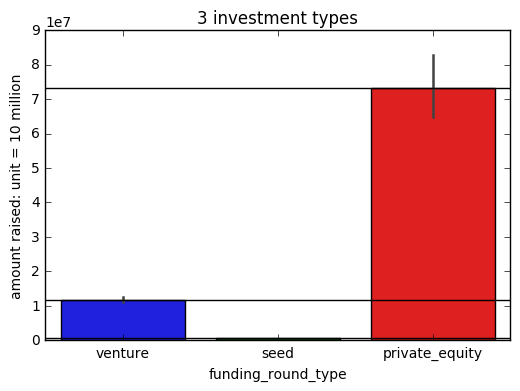

 horizantal bar shows mean on each type of investment


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_frame=master_frame[master_frame.funding_round_type.isin(['venture','seed','private_equity'])]

sea=sns.barplot(x='funding_round_type',y='raised_amount_usd',data=plot_frame)

venture_mean=plot_frame[plot_frame.funding_round_type=='venture']
venture_mean=venture_mean.raised_amount_usd.mean()

seed_mean=plot_frame[plot_frame.funding_round_type=='seed']
seed_mean=seed_mean.raised_amount_usd.mean()


private_mean=plot_frame[plot_frame.funding_round_type=='private_equity']
private_mean=private_mean.raised_amount_usd.mean()


plt.axhline(venture_mean,color="black")
plt.axhline(seed_mean,color="black")
plt.axhline(private_mean,color="black")

sea.set(title='3 investment types',ylabel='amount raised: unit = 10 million')
plt.show()
print(" horizantal bar shows mean on each type of investment")

C:\Program Files\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


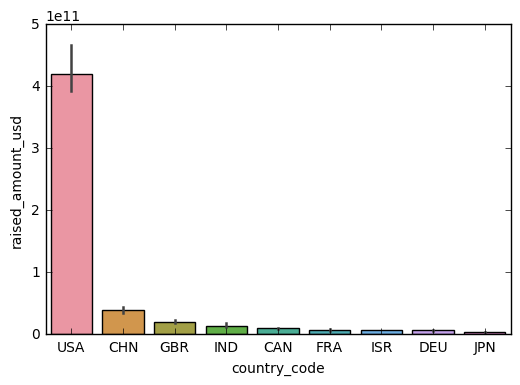

In [44]:
c=sns.barplot(x='country_code', y='raised_amount_usd', data=top9, estimator=sum, order=top)
plt.show()

In [45]:
c1_top=c1.groupby('main_sector').sum().sort_values(by='raised_amount_usd',ascending=False).head(3).index.tolist()
print("top categories in country one",c1_top)
c1=c1[c1.main_sector.isin(c1_top)]

top categories in country one ['Others', 'Social, Finance, Analytics, Advertising', 'Cleantech / Semiconductors']


In [46]:
c2_top=c2.groupby('main_sector').sum().sort_values(by='raised_amount_usd',ascending=False).head(3).index.tolist()
print("top categories in country two",c2_top)
c2=c2[c2.main_sector.isin(c2_top)]

top categories in country two ['Others', 'Cleantech / Semiconductors', 'Social, Finance, Analytics, Advertising']


In [47]:
c3_top=c3.groupby('main_sector').sum().sort_values(by='raised_amount_usd',ascending=False).head(3).index.tolist()
print("top categories in country three",c3_top)
c3=c3[c3.main_sector.isin(c3_top)]

top categories in country three ['Others', 'Social, Finance, Analytics, Advertising', 'News, Search and Messaging']


In [48]:
end=pd.concat([c1,c2,c3],axis=0)

C:\Program Files\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


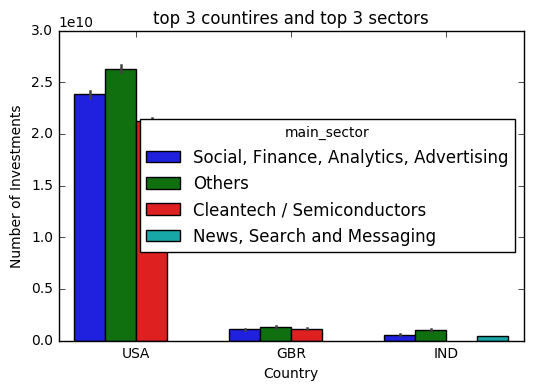

In [50]:
s=sns.barplot(x='country_code', y='raised_amount_usd', hue="main_sector", data=end,estimator=sum)
s.set(xlabel='Country', ylabel='Number of Investments')
s.set_title('top 3 countires and top 3 sectors')
plt.show()

# <i> Thank you !</i>